## Processing Camelyon 16 Dataset

This notebook shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, we need to install and run OpenSlide locally on the computer.

For the Camelyon 16 dataset, ground truth is provided as two levels:

- On a lesion-level: with detailed annotations of metastases in WSI (provided as TIFF images).
- On a patient-level: with a pN-stage label per patient (provided as XML files).

All ground truth annotations were carefully prepared under supervision of expert pathologists. For the purpose of revising the slides, additional slides stained with cytokeratin immunohistochemistry were used. If however, you encounter problems with the data set, then please report your findings at the forum.



### Starter example
The original slides and annotations are in an unusual format. We converted some of them and can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks converted.

The following is a starter example for processing data.

In [0]:
# Fixing a bug with setuptools & openslide
# https://github.com/openslide/openslide-python/issues/79
# First, run this command
# !pip uninstall setuptools

In [0]:
# Then, run this command
# !pip install setuptools==45.3.0

# After that finishes:
# 1) Comment out the ```!pip uninstall setuptools``` line above
# 2) Comment out the ``!pip install setuptools==45.3.0``` line above
# 3) Use `Runtime -> restart and run all` on the menu
# And the rest of the notebook should work

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (113 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pandas as pd
import shutil

In [0]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  57.3M      0  0:00:09  0:00:09 --:--:-- 91.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  29.5M      0 --:--:-- --:--:-- --:--:-- 29.5M


In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(tumor_mask.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

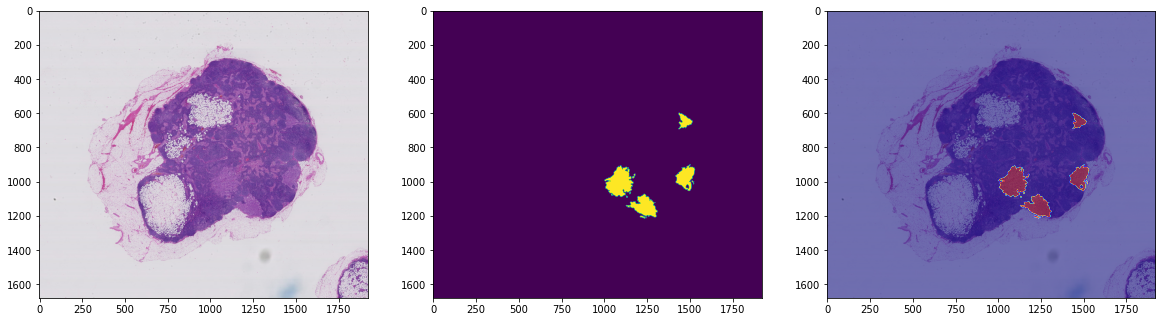

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

fig,axs = plt.subplots(1,3,figsize=(20,6))
axs[0].imshow(slide_image)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
axs[1].imshow(mask_image[:,:,0])

# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
axs[2].imshow(slide_image)
axs[2].imshow(mask_image[:,:,0], cmap='jet', alpha=0.5) # Red regions contains cancer.

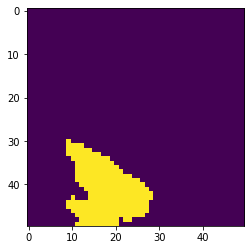

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

1680 tissue_pixels pixels (28.1 percent of the image)


Text(0.5, 1.0, 'masked tissue')

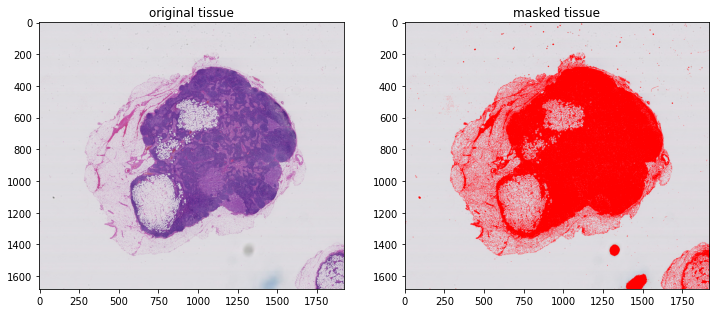

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8, verbose=False):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    tissue_pixels = (im_gray <= intensity).astype('uint8')
    indices = np.where(im_gray <= intensity)
    #tissue_pixels = list(zip(indices[0], indices[1]))
    if verbose:
        percent_tissue = len(indices[0]) / float(image.shape[0] * image.shape[1]) * 100
        return percent_tissue, tissue_pixels

    return tissue_pixels

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    masked[np.where(mask>0)] = color #here default (255,0,0) is all red
    return masked

percent_tissue, tissue_pixels = find_tissue_pixels(slide_image, verbose=True)
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

tissue_regions = apply_mask(slide_image, tissue_pixels)
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(slide_image)
axs[0].set_title('original tissue')
axs[1].imshow(tissue_regions)
axs[1].set_title('masked tissue')

### Mount Google Drive
We use the same logic to define a data processing class and use it to read and pre-process the training and validating data. 

First we need to mount the dataset from google drive.

In [70]:
from google.colab import drive
drive.mount('/content/drive/', True)

Mounted at /content/drive/


In [0]:
all_slides = np.array(['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059',\
            '075', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110'])

In [0]:
PATCH_SIZE = 299
WINDOW_SIZE = 128  #sliding window size for generating patches
WINDOW_SIZE_1 = 200
TUMOR_COLOR = (255,0,0)
SLIDE_IMAGE_PATH = '/content/drive/My Drive/slides/'
PATCH_IMAGE_PATH = '/content/drive/My Drive/patches/'
if not os.path.exists(PATCH_IMAGE_PATH):
    os.mkdir(PATCH_IMAGE_PATH)

### Observe the whole slide image samples

We can see that some of the WSI slides are not in square shape, with length larger than the twice of width,  and has non-tissue noises at the top and bottom of the slides. To remove the noise, we crop these WSI slides by 1/8 its length both from the top and from the bottom.

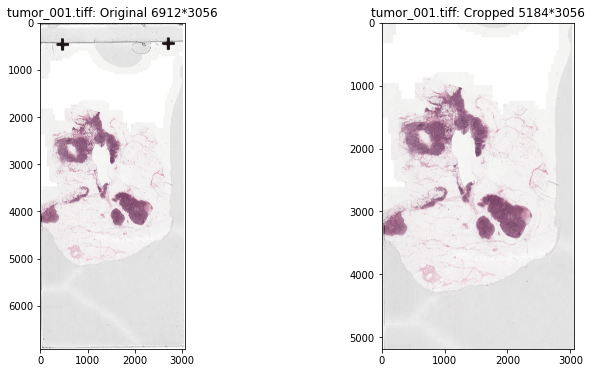

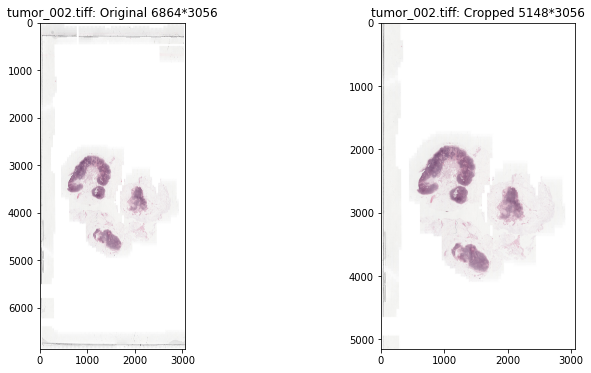

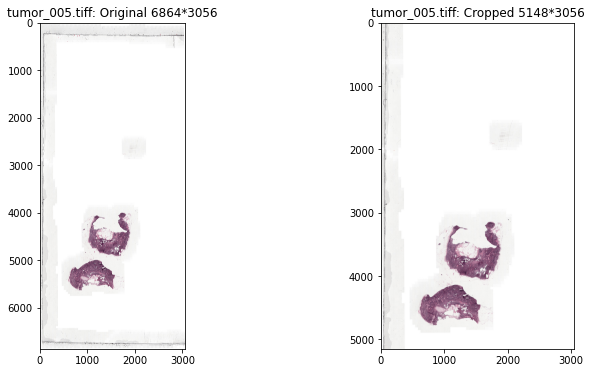

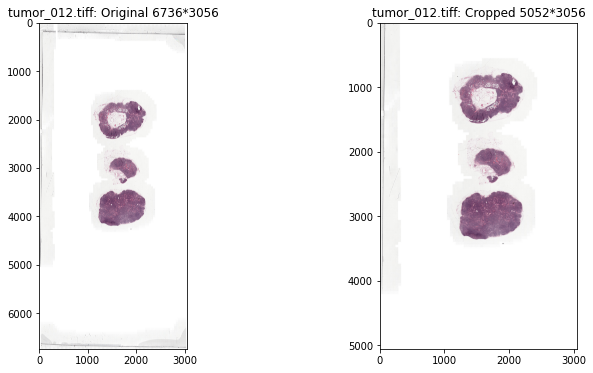

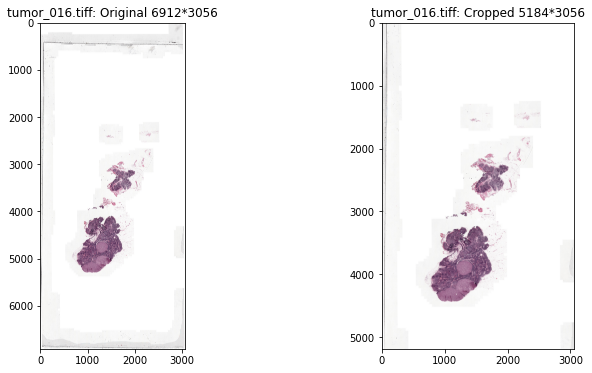

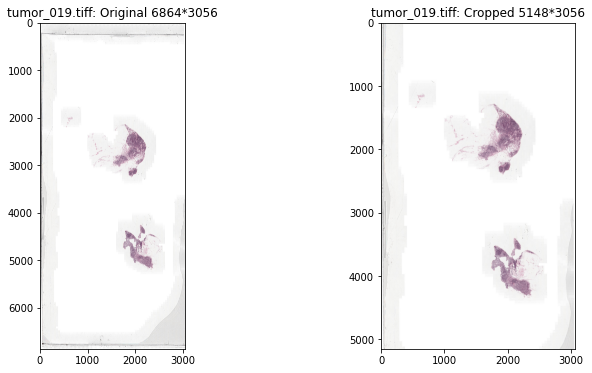

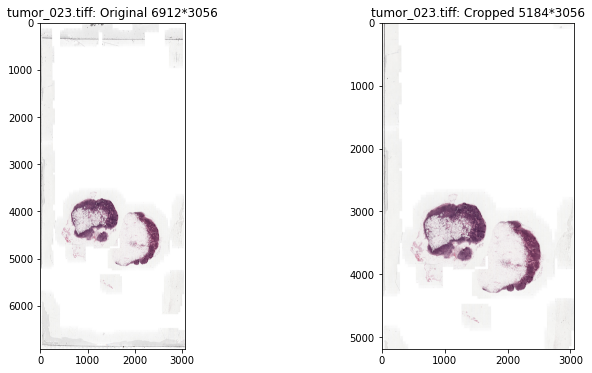

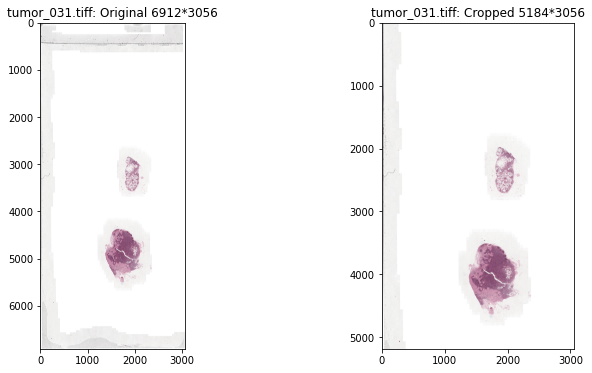

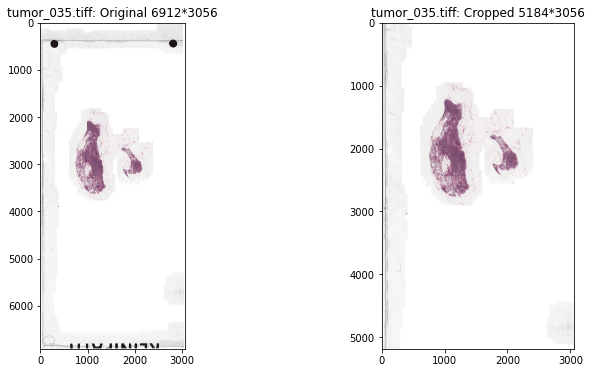

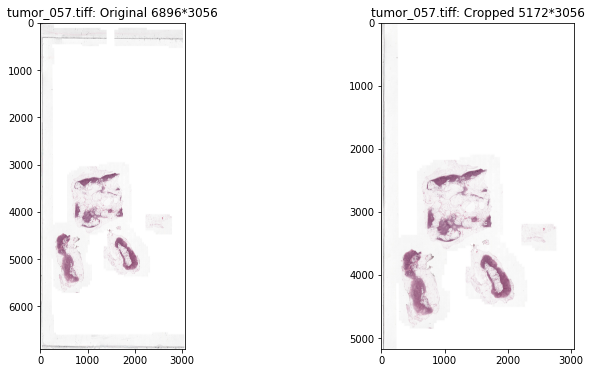

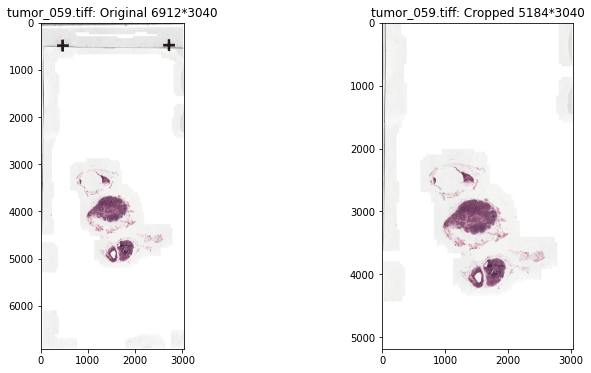

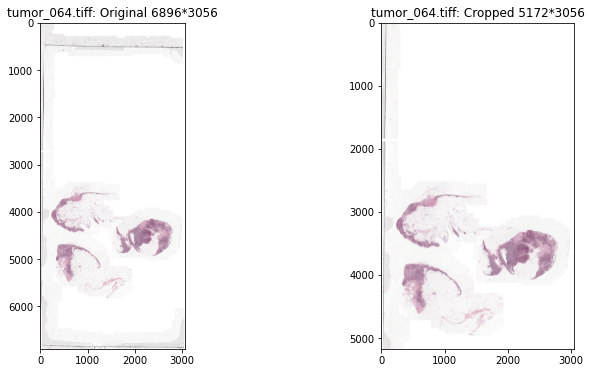

In [0]:
for img in all_slides:
    slide = open_slide(SLIDE_IMAGE_PATH+"tumor_"+img+".tif")
    slide_region = read_slide(slide, x=0, y=0, level=5, 
                              width=slide.level_dimensions[5][0], 
                              height=slide.level_dimensions[5][1])
    tumor_mask_region = read_slide(tumor_mask, x=0, y=0, level=5, 
                                   width=slide.level_dimensions[5][0], 
                                   height=slide.level_dimensions[5][1])
    ratio, slide_tissue_pixels = find_tissue_pixels(slide_region, intensity=0.5, verbose=True)
    #slide_tissue_regions = apply_mask(slide_region, slide_tissue_pixels)
    # as long as RGB sum>0 for the tumor mask image, the image has tumor
    # is_tumor = np.sum(tumor_mask_region[:,:,0])
    length, width = slide_region.shape[0],slide_region.shape[1]
    
    if length>2*width:
        fig,axs = plt.subplots(1,2, figsize=(12,6))
        axs[0].imshow(slide_region)
        axs[0].set_title(f"tumor_{img}.tiff: Original {length}*{width}")
        #crop the top and bottom 1/8 from the image to remove the noises (non-grey but not tissues)
        slide_region = slide_region[length//8:-length//8]

        axs[1].imshow(slide_region)
        length, width = slide_region.shape[0],slide_region.shape[1]
        axs[1].set_title(f"tumor_{img}.tiff: Cropped {length}*{width}")    
    
    

We can see clearly that after cropping, most of the extra noises at the boundary of the slides have been removed.

### Generate positive & negative patches

We write a function to generate all patches of the given whole slide images (WSI). When extracting the images, we use the corresponding mask regions to determine if it has tumors and only save the regions with enough tissues to avoid noises. The patch extraction follows two steps:



1.   Sliding sample (no overlap): 
use a slide window of patch_size (256*256) to slide over the WSI and crop each region with no overlap

2.   Random sample: to avoid inbalanced sample (more normal patches than tumor patches) during the sliding sample process, we further pick random regions to upsample the patches of the minority class until they have similar number as the majority class.

In [0]:
def generate_patches(images, level=5, threshold=0.4, window_size=PATCH_SIZE, is_train=True, verbose=False):
    #all_patches = []
    train_test = "train/" if is_train else "test/"
    level_patch_image_path = PATCH_IMAGE_PATH + "level_" + str(level) + "/"
    curr_patch_image_path = level_patch_image_path + train_test
    # create images saving path
    if not os.path.exists(level_patch_image_path):
        os.mkdir(level_patch_image_path)
    if not os.path.exists(curr_patch_image_path):
        os.mkdir(curr_patch_image_path)
        os.mkdir(curr_patch_image_path+'normal/')
        os.mkdir(curr_patch_image_path+'tumor/')

    for img in images:
        slide_name = 'tumor_'+img+'.tif' # only this file is available
        tumor_mask_name = 'tumor_'+img+'_mask.tif' # only this file is available
        slide_path = SLIDE_IMAGE_PATH + slide_name
        tumor_mask_path = SLIDE_IMAGE_PATH + tumor_mask_name

        if not os.path.exists(slide_path):
            raise ValueError(f'Image {slide_name} not found at this path')
        if not os.path.exists(tumor_mask_path):
            raise ValueError(f'Image {tumor_mask_name} not found at this path')

        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)
    
        factor = int(slide.level_downsamples[level])
        length = slide.level_dimensions[level][0]
        width = slide.level_dimensions[level][1]
        # the patch nums on the slide image (length nums, width nums)
        # calculate the number (remove mod and an extra window_size) to avoid margin overflow
        if width>2*length:  #need extra crop for length>>width
            crop = width//8
            # the sliding window num (also the patch num)
            window_num = [length//window_size-1,(width-crop*2)//window_size] 
            margin = [(length-window_size*window_num[0])//2, (width-window_size*window_num[1])//2] #divide the extra margin to both sides
        else:   #normal square-like image
            window_num = [length//window_size-1, width//window_size-1]
            margin = [(length-window_size*window_num[0])//2, (width-window_size*window_num[1])//2] 

        # 1. Sliding sample: use a slideing window to generate patches through a whole image slide
        n_tumor, n_normal = 0,0
        for i in range(0, window_num[0]):
            for j in range(0, window_num[1]):
                tile_x = (margin[0] + i*window_size)*factor
                tile_y = (margin[1] + j*window_size)*factor

                slide_region = read_slide(slide, x=tile_x, y=tile_y, 
                                          level=level, width=PATCH_SIZE, height=PATCH_SIZE)
                tumor_mask_region = read_slide(tumor_mask, x=tile_x, y=tile_y, 
                                               level=level, width=PATCH_SIZE, height=PATCH_SIZE)
                ratio, slide_tissue_pixels = find_tissue_pixels(slide_region, intensity=0.5, verbose=True)
                ##slide_tissue_regions = apply_mask(slide_region, slide_tissue_pixels)

                # check if the patch has tumor
                # as long as RGB sum>0 for the tumor mask image, the image has tumor
                
                tumor_center_region = tumor_mask_region[:,:,0][PATCH_SIZE//4:PATCH_SIZE//4*3, PATCH_SIZE//4:PATCH_SIZE//4*3]
                is_tumor = np.sum(tumor_center_region)
                if ratio>=threshold: #save only the most-tissue patches
                    if verbose:
                        print(f"save image {slide_name[:-4]}_{n_tumor if is_tumor else n_normal}", "as", "tumor" if is_tumor else "normal")
                    if is_tumor:
                        plt.imsave(curr_patch_image_path + 'tumor/' + img + '_' + str(n_tumor) + '.png', slide_region)
                        n_tumor += 1
                    else:
                        plt.imsave(curr_patch_image_path + 'normal/' + img + '_' + str(n_normal) + '.png', slide_region)
                        n_normal += 1
                        
                    #all_patches.append(patch)
        
        #2. Random sample: use extra random sample to upsample the minority class (i.e. tumor class)
        # keep sampling until getting the tumor region (if not, continue)
        while(is_train and n_tumor < 0.8*n_normal):
            tile_x = np.random.randint(margin[0], length-margin[0])*factor
            tile_y = np.random.randint(margin[1], width-margin[1])*factor
            
            tumor_mask_region = read_slide(tumor_mask, x=tile_x, y=tile_y, 
                                           level=level, width=PATCH_SIZE, height=PATCH_SIZE)
            # crop the center of tumor_mask to check if it is tumor
            
            tumor_center_region = tumor_mask_region[:,:,0][PATCH_SIZE//4:PATCH_SIZE//4*3, PATCH_SIZE//4:PATCH_SIZE//4*3]
            is_tumor = np.sum(tumor_center_region)
            if is_tumor:
                slide_region = read_slide(slide, x=tile_x, y=tile_y, 
                                          level=level, width=PATCH_SIZE, height=PATCH_SIZE)
                ratio, slide_tissue_pixels = find_tissue_pixels(slide_region, intensity=0.5, verbose=True)
                # only save those tumor patches with  most-tissue
                if ratio < threshold:
                    continue
                if verbose:
                    print(f"save image {slide_name[:-4]}_{n_tumor if is_tumor else n_normal}", "as", "tumor" if is_tumor else "normal")
                plt.imsave(curr_patch_image_path + 'tumor/' + img + '_' + str(n_tumor) + '.png', slide_region)
                n_tumor += 1
                #all_patches.append(patch)
        
    
    #return all_patches


### Split train & test patches

We split the training and testing dataset by two steps. 

First, we shuffle the whole slide images slides. Next, we select a slide at random into the training set and generate all patches from that slide. We keep selecting un-selected slide until the training patches size is larger than 70% of the size all patches.

In this way, we can generate around 70% train_test_split and make sure two datasets are independent and the binary classes are relatively balanced.

To build model of multi-scale approaches, we will generate patches of two different level of magnifications, i.e. level 5 and 6.

In [0]:
split = int(all_slides.size*0.7)
train_slides = all_slides[:split]
train_slides = all_slides[split:split+3]
test_slides = all_slides[split+3:]

In [0]:
np.random.shuffle(all_slides)

In [0]:
print("\n------------------generate training set--------------------\n")
generate_patches(train_slides, level=5, threshold=0.5, window_size=WINDOW_SIZE_1, is_train=True, verbose=True)
generate_patches(train_slides, level=6, threshold=0.6, window_size=WINDOW_SIZE, is_train=True, verbose=True)


------------------generate training set--------------------

save image tumor_064_0 as normal
save image tumor_064_1 as normal
save image tumor_064_2 as normal
save image tumor_064_3 as normal
save image tumor_064_4 as normal
save image tumor_064_5 as normal
save image tumor_064_6 as normal
save image tumor_064_7 as normal
save image tumor_064_8 as normal
save image tumor_064_9 as normal
save image tumor_064_10 as normal
save image tumor_064_11 as normal
save image tumor_064_0 as tumor
save image tumor_064_1 as tumor
save image tumor_064_2 as tumor
save image tumor_064_3 as tumor
save image tumor_064_12 as normal
save image tumor_064_13 as normal
save image tumor_064_14 as normal
save image tumor_064_15 as normal
save image tumor_064_16 as normal
save image tumor_064_17 as normal
save image tumor_064_18 as normal
save image tumor_064_4 as tumor
save image tumor_064_5 as tumor
save image tumor_064_19 as normal
save image tumor_064_6 as tumor
save image tumor_064_20 as normal
save image

In [0]:
print("\n-------------------generate testing set---------------------\n")
generate_patches(test_slides, level=5, threshold=0.5, window_size=WINDOW_SIZE_1, is_train=False, verbose=True)
generate_patches(test_slides, level=6, threshold=0.4, window_size=WINDOW_SIZE_1, is_train=False, verbose=True)


-------------------generate testing set---------------------

save image tumor_023_0 as normal
save image tumor_023_1 as normal
save image tumor_023_2 as normal
save image tumor_023_3 as normal
save image tumor_023_4 as normal
save image tumor_023_5 as normal
save image tumor_023_6 as normal
save image tumor_023_7 as normal
save image tumor_023_8 as normal
save image tumor_023_9 as normal
save image tumor_023_10 as normal
save image tumor_023_11 as normal
save image tumor_023_12 as normal
save image tumor_023_13 as normal
save image tumor_023_14 as normal
save image tumor_023_15 as normal
save image tumor_023_16 as normal
save image tumor_023_17 as normal
save image tumor_023_18 as normal
save image tumor_023_19 as normal
save image tumor_023_0 as tumor
save image tumor_023_20 as normal
save image tumor_023_21 as normal
save image tumor_023_22 as normal
save image tumor_023_23 as normal
save image tumor_023_24 as normal
save image tumor_023_1 as tumor
save image tumor_023_25 as normal

In [0]:
print("level 5")
train_normal_size_5 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_5/'+'train/normal/')]) 
train_tumor_size_5 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_5/'+'train/tumor/')])
print(f"train: normal {train_normal_size}, tumor {train_tumor_size}, total {train_normal_size+train_tumor_size}")

test_normal_size_5 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_5/'+'test/normal/')]) 
test_tumor_size_5 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_5/'+'test/tumor/')])
print(f"test: normal {test_normal_size}, tumor {test_tumor_size}, total {test_normal_size+test_tumor_size}")


level 5
train: normal 998, tumor 819, total 1817
test: normal 121, tumor 11, total 132


In [0]:
print("level 6")
train_normal_size_6 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_6/'+'train/normal/')]) 
train_tumor_size_6 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_6/'+'train/tumor/')])
print(f"train: normal {train_normal_size}, tumor {train_tumor_size}, total {train_normal_size+train_tumor_size}")

test_normal_size_6 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_6/'+'test/normal/')]) 
test_tumor_size_6 = len([name for name in os.listdir(PATCH_IMAGE_PATH+'level_6/'+'test/tumor/')])
print(f"test: normal {test_normal_size}, tumor {test_tumor_size}, total {test_normal_size+test_tumor_size}")


level 6
train: normal 998, tumor 819, total 1817
test: normal 121, tumor 11, total 132


To ensure the robustess of the model, we will also generate the validation set. Since the training set is much larger than the testing set, we will randomly pick 20% of the training set patches to be the validation set and move them to the new directory.

In [0]:
if not os.path.exists(PATCH_IMAGE_PATH+"level_5/val/"):
    os.mkdir(PATCH_IMAGE_PATH+"level_5/val/")
    os.mkdir(PATCH_IMAGE_PATH+"level_5/val/normal/")
    os.mkdir(PATCH_IMAGE_PATH+"level_5/val/tumor/")

if not os.path.exists(PATCH_IMAGE_PATH+"level_6/val/"):
    os.mkdir(PATCH_IMAGE_PATH+"level_6/val/")
    os.mkdir(PATCH_IMAGE_PATH+"level_6/val/normal/")
    os.mkdir(PATCH_IMAGE_PATH+"level_6/val/tumor/")

In [75]:
print("\n-------------------generate validation set---------------------")
print("----------------randomly pick from the training set------------------\n")


val_normal_size_5 = train_normal_size_5//5
val_tumor_size_5 = train_tumor_size_5//5
i_normal, i_tumor = 0,0
print("\n moving level 5 patch images\n")
while(i_normal < val_normal_size_5 or i_tumor<val_tumor_size_5):
    path = PATCH_IMAGE_PATH +"level_5/train/"

    normal = np.random.choice(os.listdir(path + "normal/"))
    normal_file = path + "normal/" + normal
    move_normal_file = PATCH_IMAGE_PATH+"level_5/val/normal/" + normal
    
    tumor = np.random.choice(os.listdir(path + "tumor/"))
    tumor_file = path + "tumor/" + tumor
    move_tumor_file = PATCH_IMAGE_PATH+"level_5/val/tumor/" + tumor

    if not os.path.exists(move_normal_file) and i_normal<val_normal_size_5:
        print("move", normal_file, "to ",move_normal_file)
        shutil.move(normal_file, move_normal_file)
        i_normal += 1
    if not os.path.exists(move_tumor_file) and i_tumor<val_tumor_size_5:
        print("move", tumor_file, "to ",move_tumor_file)
        shutil.move(tumor_file, move_tumor_file)
        i_tumor += 1

# check if all validation set has been moved
assert i_normal==val_normal_size_5, i_tumor==val_tumor_size_5



-------------------generate validation set---------------------
----------------randomly pick from the training set------------------


 moving level 5 patch images

move /content/drive/My Drive/patches/level_5/train/normal/081_50.png to  /content/drive/My Drive/patches/level_5/val/normal/081_50.png
move /content/drive/My Drive/patches/level_5/train/tumor/096_23.png to  /content/drive/My Drive/patches/level_5/val/tumor/096_23.png
move /content/drive/My Drive/patches/level_5/train/normal/001_26.png to  /content/drive/My Drive/patches/level_5/val/normal/001_26.png
move /content/drive/My Drive/patches/level_5/train/tumor/084_11.png to  /content/drive/My Drive/patches/level_5/val/tumor/084_11.png
move /content/drive/My Drive/patches/level_5/train/normal/035_1.png to  /content/drive/My Drive/patches/level_5/val/normal/035_1.png
move /content/drive/My Drive/patches/level_5/train/tumor/064_38.png to  /content/drive/My Drive/patches/level_5/val/tumor/064_38.png
move /content/drive/My Drive/pa

In [76]:
val_normal_size_6 = train_normal_size_6//5
val_tumor_size_6 = train_tumor_size_6//5
i_normal, i_tumor = 0,0
print("\n moving level 6 patch images\n")
while(i_normal < val_normal_size_6 or i_tumor<val_tumor_size_6):
    path = PATCH_IMAGE_PATH +"level_6/train/"

    normal = np.random.choice(os.listdir(path + "normal/"))
    normal_file = path + "normal/" + normal
    move_normal_file = PATCH_IMAGE_PATH+"level_6/val/normal/" + normal
    
    tumor = np.random.choice(os.listdir(path + "tumor/"))
    tumor_file = path + "tumor/" + tumor
    move_tumor_file = PATCH_IMAGE_PATH+"level_6/val/tumor/" + tumor

    if not os.path.exists(move_normal_file) and i_normal<val_normal_size_6:
        print("move", normal_file, "to ",move_normal_file)
        shutil.move(normal_file, move_normal_file)
        i_normal += 1
    if not os.path.exists(move_tumor_file) and i_tumor<val_tumor_size_6:
        print("move", tumor_file, "to ",move_tumor_file)
        shutil.move(tumor_file, move_tumor_file)
        i_tumor += 1

assert i_normal==val_normal_size_6, i_tumor==val_tumor_size_6


 moving level 6 patch images

move /content/drive/My Drive/patches/level_6/train/normal/081_64.png to  /content/drive/My Drive/patches/level_6/val/normal/081_64.png
move /content/drive/My Drive/patches/level_6/train/tumor/096_41.png to  /content/drive/My Drive/patches/level_6/val/tumor/096_41.png
move /content/drive/My Drive/patches/level_6/train/normal/016_31.png to  /content/drive/My Drive/patches/level_6/val/normal/016_31.png
move /content/drive/My Drive/patches/level_6/train/tumor/096_33.png to  /content/drive/My Drive/patches/level_6/val/tumor/096_33.png
move /content/drive/My Drive/patches/level_6/train/normal/081_89.png to  /content/drive/My Drive/patches/level_6/val/normal/081_89.png
move /content/drive/My Drive/patches/level_6/train/tumor/035_24.png to  /content/drive/My Drive/patches/level_6/val/tumor/035_24.png
move /content/drive/My Drive/patches/level_6/train/normal/091_8.png to  /content/drive/My Drive/patches/level_6/val/normal/091_8.png
move /content/drive/My Drive/pat

### Check train & test images

Now since we have gotten the balanced data, we need to divide the train and test dataset for model training.

/content/drive/My Drive/patches/level_5/train/tumor/
tumor patches


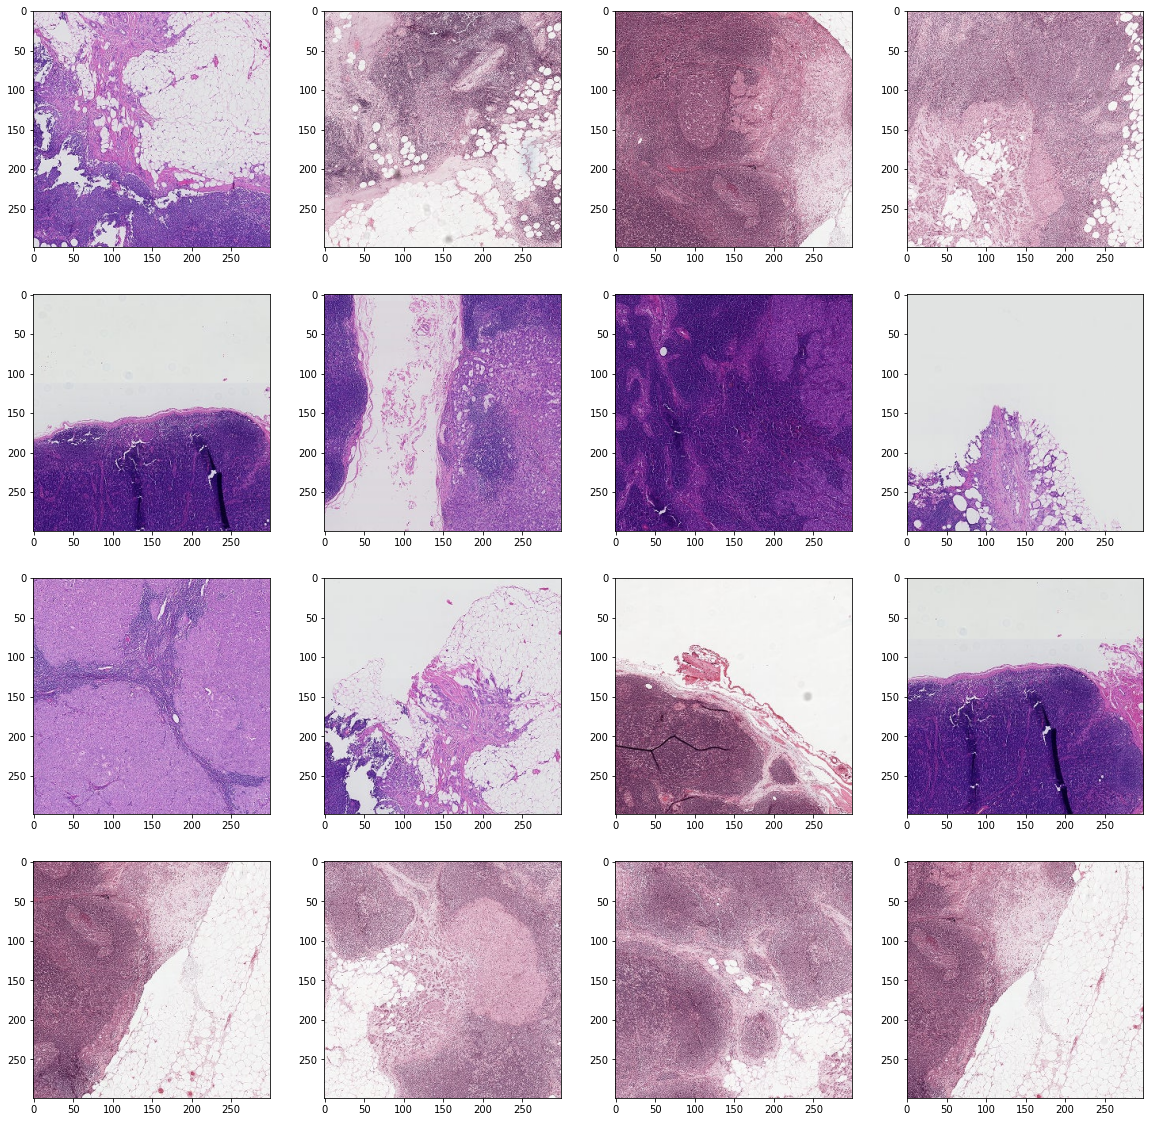

In [77]:
fig,axs = plt.subplots(4,4,figsize=(20,20))
patch_image_path = PATCH_IMAGE_PATH + "level_5/" + "train/tumor/"
print(patch_image_path)
print("tumor patches")

for i in range(4*4):
    name = np.random.choice(os.listdir(patch_image_path))
    img = plt.imread(patch_image_path + name)
    axs[i//4][i%4].imshow(img)

/content/drive/My Drive/patches/level_5/train/normal/
normal patches


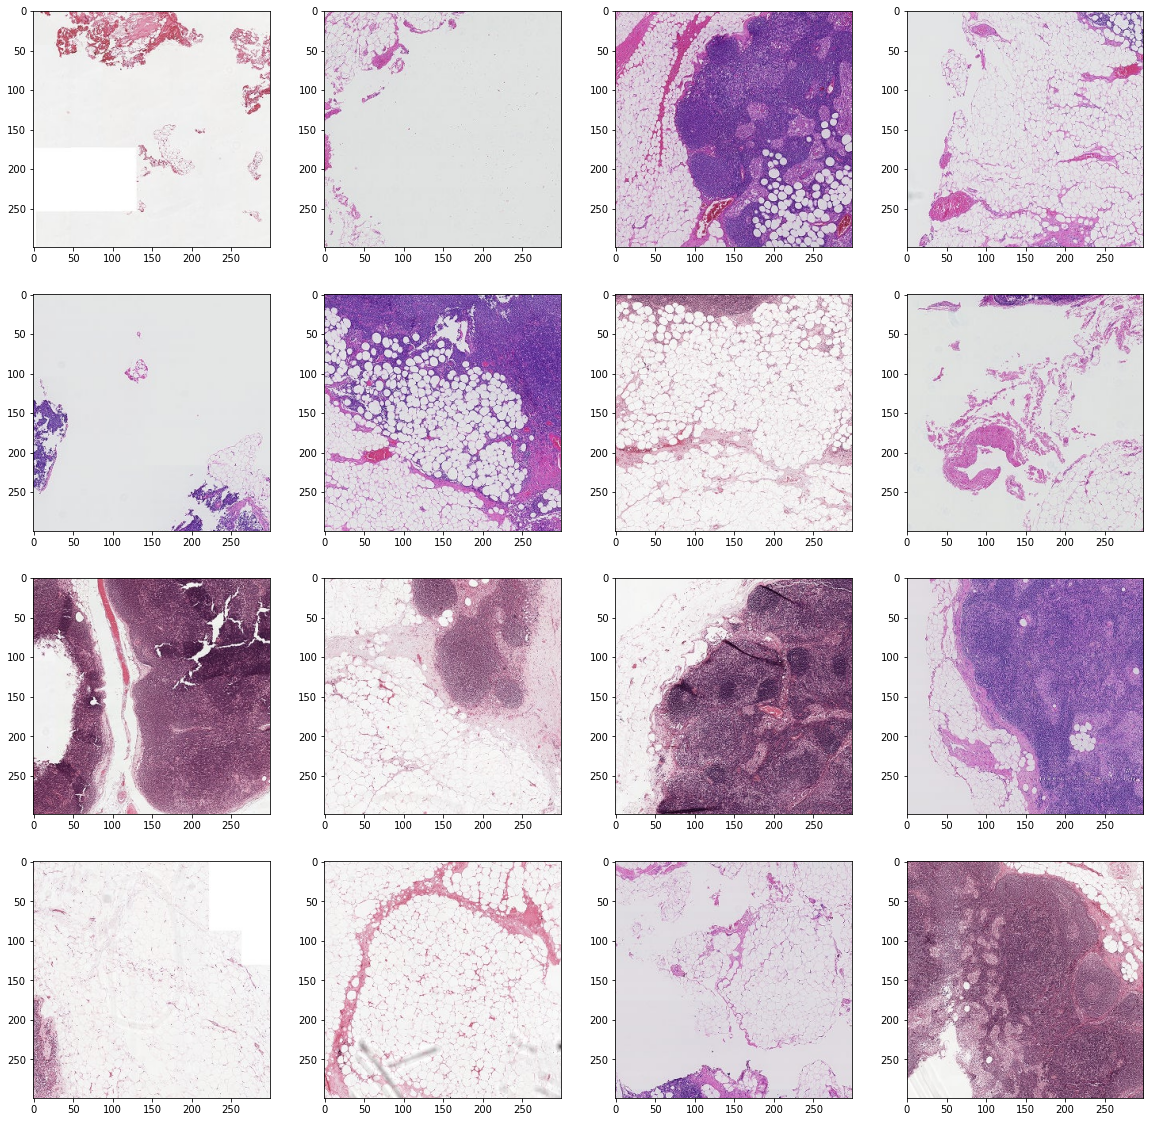

In [78]:
fig,axs = plt.subplots(4,4,figsize=(20,20))
patch_image_path = PATCH_IMAGE_PATH + "level_5/" + "train/normal/"
print(patch_image_path)
print("normal patches")

for i in range(4*4):
    name = np.random.choice(os.listdir(patch_image_path))
    img = plt.imread(patch_image_path + name)
    axs[i//4][i%4].imshow(img)